In [1]:
import logging
import os
import pandas as pd
import matplotlib.pyplot as plt
import workflow_steps as wflow
import workflow_steps_utils as utils

# Logger
logging.basicConfig(
    format='%(asctime)s,%(msecs)03d %(name)s %(levelname)s %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    level=logging.ERROR,
    filename="logs/workflows.log"
)
logger = logging.getLogger("RootLogger") # Root logger

# Define step names
CONSTANTS = {
    'step_1': 'couple_model_tortion',
    'step_2': 'coupled_model_adaptors',
    'step_3': 'coupled_decoupled',
    'step_4': 'local_cosim'
}

ModuleNotFoundError: No module named 'SPARQLWrapper'

In [2]:
## LoadStep
sparql = SPARQLWrapper(QUERY_SERVER_URL)
sparql.setReturnFormat(JSON)
logger = logging.getLogger("LoadStep")

load_steps_objects = [{'o': 'loadE5', 'a': 'produces'}, {'o': 'loadE6', 'a': 'produces'} ]

models = {}
for params in load_steps_objects:
    load_step = LoadStep(sparql, logger, params)
    response = load_step.get_models('model_name')
    for item in response:
        models[item['key']] = item['value']
    
logger.info("LoadStep returned the following models:")
for key in models.keys():
    logger.info(f"{key} => {models[key]}")


In [3]:
## SimulateStep
sparql = SPARQLWrapper(QUERY_SERVER_URL)
sparql.setReturnFormat(JSON)
logger = logging.getLogger("SimulateStep")

simulate_steps_objects = [{'o': 'simE5', 'a': ['consumes', 'produces'], 'path': 'service_modelica', 
                           'cmd': f"! java -jar ..\\cosim_modelica\\maestro.jar import Sg1 -output=results -v --interpret local_cosim.json"}]

for params in simulate_steps_objects:
    # instantiate SimulatorStep
    simulate_step = SimulateStep(sparql, logger)

    # top-level dictionary to store the simulation models
    simulate_model = {'cmd': params['cmd'] if 'cmd' in params else OMC_CMD, 'path': params['path'] if 'path' in params else ''}
    
    for action in params['a']:
        # add action to query_params
        params['a'] = action
        simulate_step.set_params(params)

        # store step actions
        simulate_model[action] = simulate_step.get_model()

        # add simulation file as step
        simulate_model['consumer_file'] = models[simulate_model['consumes']]

    # run simulation
    simulate_step.run_simulation(simulate_model)


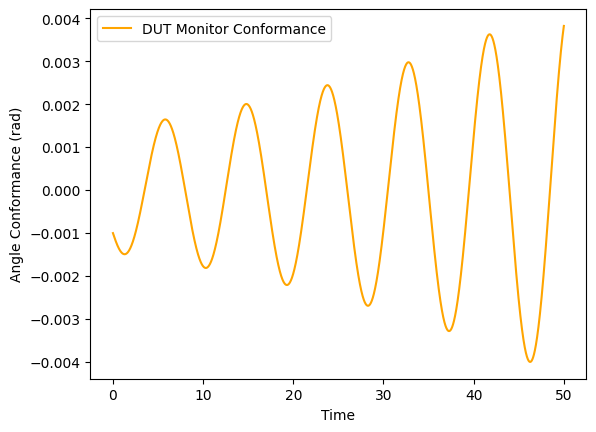

In [4]:
SIMULATION_GRAPH_DATA = {
'compE4': {
    'data': {
      0: [{'x': 'time', 'y': '{Monitor}.monitor.out_conformance', 'label': 'DUT Monitor Conformance', 'line': 'solid', 'color': 'orange'}],
    }
  }
}

## CompareStep
sparql = SPARQLWrapper(QUERY_SERVER_URL)
sparql.setReturnFormat(JSON)
logger = logging.getLogger("CompareStep")

compare_steps_objects = ['compE4']

for step in compare_steps_objects:
    compare_step = CompareStep(sparql, logger)
    simulation_data = SIMULATION_GRAPH_DATA[step]
    simulation_data['files'] = compare_step.get_data_files(step)

    compare_step.plot_graph(simulation_data, x_label='Time', y_label='Angle Conformance (rad)', start_from=5)

In [5]:
from workflow_steps_utils import RabbitMQDockerService

# Start RabbitMQ server
rabbitmq_docker_service = RabbitMQDockerService(logging.getLogger('RabbitMQDockerService'), "rabbitmq-server")
rabbitmq_docker_service.start()


rabbitmq-server not ready - Exception: ConnectionError
rabbitmq-server not ready - Exception: ConnectionError
rabbitmq-server not ready - Exception: ConnectionError
rabbitmq-server not ready - Exception: ConnectionError
rabbitmq-server not ready - Exception: ConnectionError
rabbitmq-server not ready - Exception: ConnectionError
rabbitmq-server not ready - Exception: ConnectionError
rabbitmq-server not ready - Exception: ConnectionError
rabbitmq-server not ready - Exception: ConnectionError
rabbitmq-server not ready - Exception: ConnectionError


In [6]:
## SimulateStep
sparql = SPARQLWrapper(QUERY_SERVER_URL)
sparql.setReturnFormat(JSON)
logger = logging.getLogger("SimulateStep")

simulate_steps_objects = [
    {'o': 'simE6', 'a': ['consumes', 'produces'], 'path': 'monitor_service', 'method': 'process', 'delete_file': 2, 
     'cmd': f"python csv_recorder.py csv_recorder.csv"},


    
    {'o': 'simE7', 'a': ['consumes'], 'path': 'monitor_service', 'method': 'process', 'cmd': f"python dut_monitor.py"},
    {'o': 'simE8', 'a': ['consumes', 'produces'], 'path': 'monitor_service', 'method': 'process',
     'cmd': f"python csv_streamer.py ../service_modelica/results/outputs.csv"},


    {'o': 'simE9', 'a': ['consumes', 'produces'], 'path': 'monitor_service', 'method': 'process', 'delete_file': 2, 
     'cmd': f"python csv_recorder.py csv_recorder_with_fmu.csv"},

    {'o': 'simE10', 'a': ['consumes', 'produces'], 'path': 'monitor_service', 'method': 'process', 
     'cmd': f"python dut_monitor_fmu.py ../service_modelica/fmus/DutMonitor/"},
    # {'o': 'simE11', 'a': ['consumes', 'produces'], 'path': 'monitor_service', 'method': 'process', 
    #  'cmd': f"python csv_streamer.py ../service_modelica/results/outputs.csv"},
]

for params in simulate_steps_objects:
    simulate_step = SimulateStep(sparql, logger)

    simulate_model = {
        'cmd': params['cmd'] if 'cmd' in params else OMC_CMD, 
        'path': params['path'] if 'path' in params else '',
        'method': params['method'] if 'method' in params else '',
        'produces': '',
        'consumes': '',
        'delete_file': params['delete_file'] if 'delete_file' in params else 0
    }

    for action in params['a']:
        params['a'] = action
        simulate_step.set_params(params)

        # store step actions
        simulate_model[action] = simulate_step.get_model()
        
        # add simulation file as step
        simulate_model['consumer_file'] = models[simulate_model['consumes']]

    # run simulation
    simulate_step.run_simulation(simulate_model)
    

Run with process Id: 26184
Run with process Id: 24104
Run with process Id: 25220
Run with process Id: 22544
Run with process Id: 11828


In [6]:
# Validate services are not running


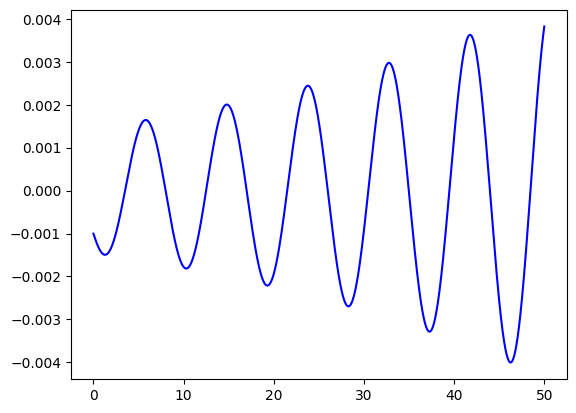

In [7]:
# SIMULATION_GRAPH_DATA = {
#     'compE5': {
#         'data': {
#             0: [{'x': 'time', 'y': '{Monitor}.monitor.out_conformance', 'label': 'DUT Monitor Conformance', 'line': 'solid', 'color': 'blue'}],
#             1: [{'x': 'time', 'y': 'conformance', 'label': 'DUT Monitor Service Conformance', 'line': 'dotted', 'color': 'orange'}],
#         }
#     }
# }

# ## CompareStep
# sparql = SPARQLWrapper(QUERY_SERVER_URL)
# sparql.setReturnFormat(JSON)
# logger = logging.getLogger("CompareStep")

# compare_steps_objects = ['compE5']

# for step in compare_steps_objects:
#     compare_step = CompareStep(sparql, logger)
#     simulation_data = SIMULATION_GRAPH_DATA[step]
#     simulation_data['files'] = compare_step.get_data_files(step)

#     compare_step.plot_graph(simulation_data, x_label='Time', y_label='Angle Conformance (rad)', start_from=5)

In [9]:
# Shutdown RabbitMQ server
# rabbitmq_docker_service.stop()